# Example 1: Inference for a Normal Mean

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]


Output()

Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

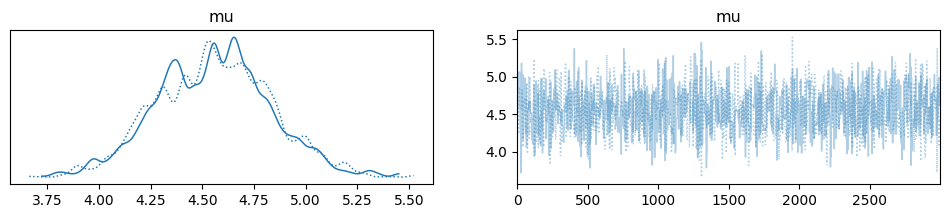

In [1]:
import pymc as pm
import arviz as az
import numpy as np

np.random.seed(42)
y = np.random.normal(loc=5, scale=2, size=50)

with pm.Model() as mh_model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = 2.0
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(3000, tune=2000, chains=2, step=pm.Metropolis())

az.plot_trace(idata, var_names=["mu"])


<Axes: title={'center': 'mu'}>

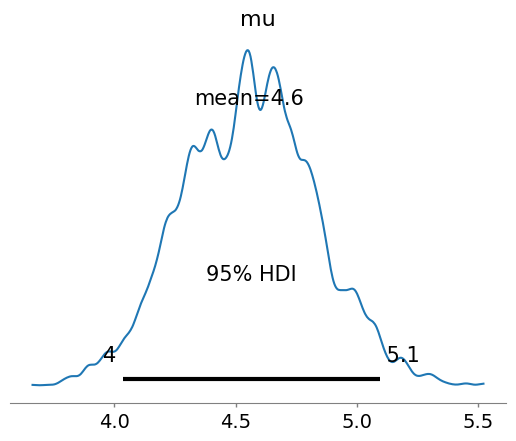

In [2]:
az.plot_posterior(idata, var_names=["mu"], hdi_prob=0.95)


# Example 2: Bayesian Linear Regression

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'beta0'}>,
       <Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

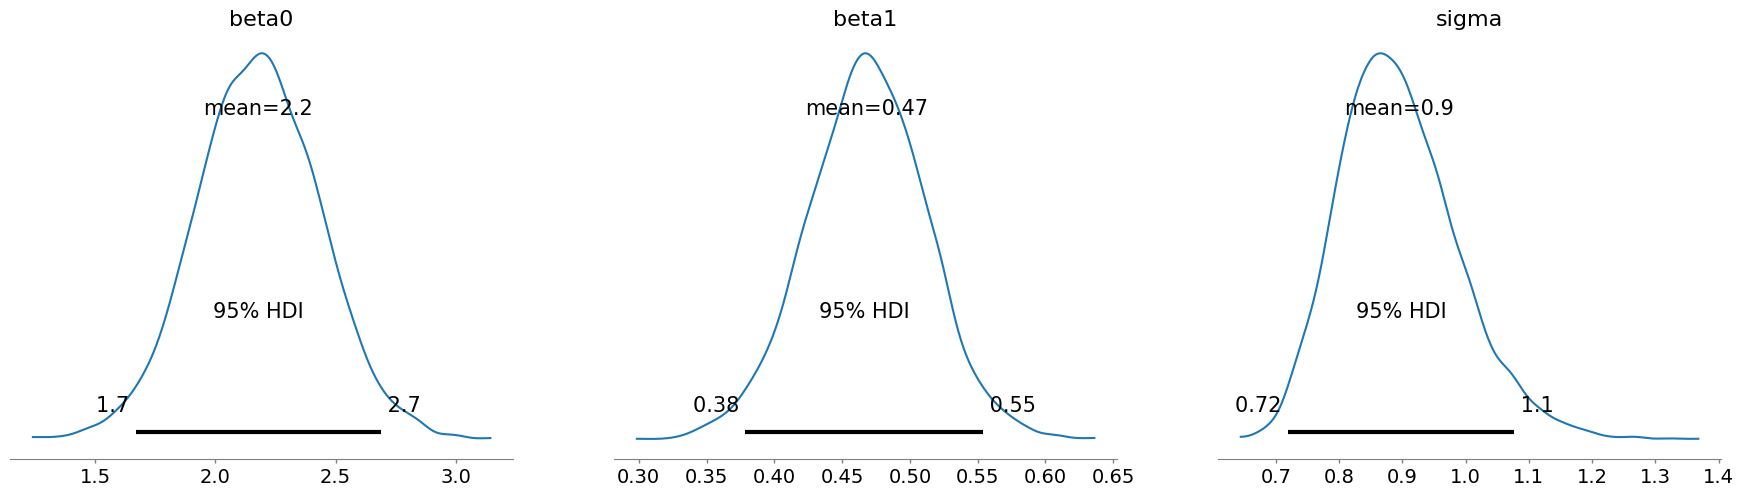

In [3]:
x = np.linspace(0, 10, 50)
y = 2 + 0.5*x + np.random.normal(0, 1, 50)

with pm.Model() as reg_model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(3000, tune=2000, chains=2, target_accept=0.95)

az.plot_posterior(idata, var_names=["beta0","beta1","sigma"], hdi_prob=0.95)


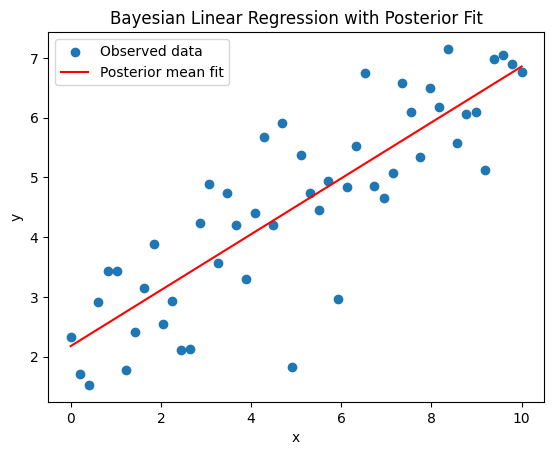

In [4]:
import matplotlib.pyplot as plt

beta0_samples = idata.posterior["beta0"].mean().values
beta1_samples = idata.posterior["beta1"].mean().values

plt.scatter(x, y, label="Observed data")
plt.plot(x, beta0_samples + beta1_samples*x, color="red", label="Posterior mean fit")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian Linear Regression with Posterior Fit")
plt.show()
